In [ ]:
from util import load_original_data
load_original_data(0.1, 0.1)

In [ ]:
from util import create_dataset
create_dataset('data/original_dataset_0.80_0.10_0.10',5000, down_sample=True)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pickle
import numpy as np
f1 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/train_data', 'rb')
X_sequence_train, X_feature_train, X_image_train, Y_train = pickle.load(f1)
f1.close()
f2 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/val_data', 'rb')
X_sequence_val, X_feature_val, X_image_val, Y_val = pickle.load(f2)
f2.close()
f3 = open('data/split_0.80_0.10_0.10_aug_to_2500_down_sample_True_instance0-9/test_data', 'rb')
X_sequence_test, X_feature_test, X_image_test, Y_test = pickle.load(f3)
f3.close()

from keras.preprocessing.sequence import pad_sequences
X_sequence_train_paded = pad_sequences(X_sequence_train, dtype='float', padding='post', value = np.nan)
X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
# 先pad再预处理，因为pad可以把array的list转为ndarray

from util import preprocess
X_sequence_train_trimed = preprocess(X_sequence_train_paded)
X_sequence_val_trimed = preprocess(X_sequence_val_paded)
X_sequence_test_trimed = preprocess(X_sequence_test_paded)

def build_channel(data):
    X = []
    for image in data:
        X.append(image.reshape(128, 128, 1))
    return X
X_image_train = np.array(build_channel(X_image_train))
X_image_val = np.array(build_channel(X_image_val))
X_image_test = np.array(build_channel(X_image_test))
X_feature_train = np.array(X_feature_train)
X_feature_val = np.array(X_feature_val)
X_feature_test = np.array(X_feature_test)
Y_train = np.array(Y_train)-1 # 文件夹名从1开始但是标签从0开始
Y_val = np.array(Y_val)-1
Y_test = np.array(Y_test)-1

In [169]:


def multi_input_model(sequence_shape, image_shape, feature_shape, num_classes):

    sequence_inputs = keras.Input(shape=sequence_shape, name='sequence')
    masking_layer = layers.Masking(mask_value=0)
    x1 = masking_layer(sequence_inputs)
    x1 = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x1)
    x1 = layers.Bidirectional(layers.GRU(64))(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Dense(128, activation="relu")(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Dense(32, activation="relu")(x1)

    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=32, kernel_size=(16,16), strides=2, activation="relu", padding='same')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(8,8), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x2)

    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = layers.Dense(32, activation="relu")(feature_inputs)
    x3 = layers.Dense(32, activation="relu")(x3)

    x = layers.concatenate([x1, x2, x3])
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=[sequence_inputs, image_inputs, feature_inputs], outputs=outputs)
    return model

In [170]:
def rnn_with_feature(sequence_shape, feature_shape, num_classes):
    sequence_inputs = keras.Input(shape=sequence_shape, name='sequence')
    masking_layer = layers.Masking(mask_value=0)
    x1 = masking_layer(sequence_inputs)
    x1 = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x1)
    x1 = layers.Bidirectional(layers.GRU(64))(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Dense(128, activation="relu")(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Dense(32, activation="relu")(x1)

    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = layers.Dense(32, activation="relu")(feature_inputs)
    x3 = layers.Dense(16, activation="relu")(x3)

    x = layers.concatenate([x1, x3])
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=[sequence_inputs, feature_inputs], outputs=outputs)
    return model

In [153]:
def cnn(image_shape,  num_classes):
    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=32, kernel_size=(16,16), strides=2, activation="relu", padding='same')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(8,8), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(128, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer='l1')(x2)
    model = keras.Model(inputs=image_inputs, outputs=outputs)
    return model

In [164]:
def cnn_with_feature(image_shape, feature_shape, num_classes):
    
    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=32, kernel_size=(16,16), strides=2, activation="relu", padding='same')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(8,8), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=(4,4), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x2)
    
    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(feature_inputs)
    x3 = layers.Dense(32, activation="relu", kernel_regularizer='l1')(x3)

    x = layers.concatenate([x2, x3])
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer='l1')(x)
    model = keras.Model(inputs=[image_inputs, feature_inputs], outputs=outputs)
    return model

In [172]:
# model = multi_input_model(sequence_shape=(None, 3), image_shape=(128, 128, 1), 
#                         feature_shape=(2,), num_classes=11)
model = rnn_with_feature(sequence_shape=(None, 3),feature_shape=(2,), num_classes=11)
# model = cnn_with_feature(image_shape=(128, 128, 1), feature_shape=(2,), num_classes=11)
# model = cnn(image_shape=(128, 128, 1), num_classes=11)
# model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    run_eagerly=False,
)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath='models/rnn_with_feature_test/model_{epoch}',
    save_freq='epoch'),
  keras.callbacks.TensorBoard(log_dir='models/rnn_with_feature_test/logs')
]

2022-10-13 09:46:57.282839: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-13 09:46:57.282873: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-13 09:46:58.176756: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-13 09:46:58.176973: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [173]:
# X_train = {'sequence':X_sequence_train_trimed, 'image':X_image_train, 'feature':X_feature_train}
# X_val = {'sequence':X_sequence_val_trimed, 'image':X_image_val, 'feature':X_feature_val}
X_train = {'sequence':X_sequence_train_trimed, 'feature':X_feature_train}
X_val = {'sequence':X_sequence_val_trimed, 'feature':X_feature_val}
# X_train = {'image':X_image_train, 'feature':X_feature_train}
# X_val = {'image':X_image_val, 'feature':X_feature_val}
model.fit(X_train, Y_train, batch_size=32, epochs=50, 
        validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/50
  1/860 [..............................] - ETA: 2:11:36 - loss: 12.3513 - acc: 0.0781

2022-10-13 09:47:14.880861: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-13 09:47:14.880898: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/860 [..............................] - ETA: 13:55 - loss: 11.2004 - acc: 0.0703  

2022-10-13 09:47:15.781431: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-13 09:47:15.781967: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-13 09:47:15.845329: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 6817 callback api events and 6814 activity events. 
2022-10-13 09:47:15.960311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-13 09:47:16.091415: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: models/rnn_with_feature_test/logs/train/plugins/profile/2022_10_13_09_47_15

2022-10-13 09:47:16.178172: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to models/rnn_with_feature_test/logs/train/plugins/profile/2022_10_13_09_47_15/dell-Precision-7920-Tower.trace.json.gz
2022-10-13 09:47:16.267247: I tensorflow/core/pro

860/860 [==============================] - 101s 107ms/step - loss: 2.6330 - acc: 0.2515 - val_loss: 1.7740 - val_acc: 0.4077


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1/assets


Epoch 2/50
860/860 [==============================] - 85s 99ms/step - loss: 1.6091 - acc: 0.4284 - val_loss: 1.2474 - val_acc: 0.6063


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2/assets


Epoch 3/50
860/860 [==============================] - 85s 99ms/step - loss: 1.0332 - acc: 0.6477 - val_loss: 0.8511 - val_acc: 0.7226


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3/assets


Epoch 4/50
860/860 [==============================] - 63s 73ms/step - loss: 0.7660 - acc: 0.7524 - val_loss: 0.6567 - val_acc: 0.7886


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4/assets


Epoch 5/50
860/860 [==============================] - 53s 62ms/step - loss: 0.6194 - acc: 0.8006 - val_loss: 0.5900 - val_acc: 0.7992


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_5/assets


Epoch 6/50
860/860 [==============================] - 54s 63ms/step - loss: 0.5366 - acc: 0.8261 - val_loss: 0.5363 - val_acc: 0.8311


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_6/assets


Epoch 7/50
860/860 [==============================] - 54s 63ms/step - loss: 0.4703 - acc: 0.8488 - val_loss: 0.5440 - val_acc: 0.8244


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_7/assets


Epoch 8/50
860/860 [==============================] - 55s 64ms/step - loss: 0.4241 - acc: 0.8621 - val_loss: 0.5696 - val_acc: 0.8155


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_8/assets


Epoch 9/50
 71/860 [=>............................] - ETA: 44s - loss: 0.3923 - acc: 0.8675

KeyboardInterrupt: 

2022-10-13 12:46:45.174602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 12:46:46.614918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22245 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:73:00.0, compute capability: 8.6
2022-10-13 12:46:46.619781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22300 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:d5:00.0, compute capability: 8.6
2022-10-13 12:46:49.348820: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs 

(11, 11)
Normalized confusion matrix
[[7.61574074e-01 0.00000000e+00 4.62962963e-03 1.55092593e-01
  2.31481481e-03 0.00000000e+00 2.31481481e-03 0.00000000e+00
  0.00000000e+00 7.17592593e-02 2.31481481e-03]
 [5.33333333e-03 8.74666667e-01 9.86666667e-02 0.00000000e+00
  8.00000000e-03 0.00000000e+00 8.00000000e-03 0.00000000e+00
  5.33333333e-03 0.00000000e+00 0.00000000e+00]
 [2.00000000e-02 1.60000000e-01 7.40000000e-01 6.00000000e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.00000000e-02 0.00000000e+00]
 [2.35294118e-01 0.00000000e+00 0.00000000e+00 7.64705882e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.06382979e-03 1.06382979e-03 1.06382979e-03 0.00000000e+00
  7.92021277e-01 7.07446809e-02 1.23404255e-01 5.31914894e-04
  0.00000000e+00 1.06382979e-03 9.04255319e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.11111111e-02 9.64444444e-01 0.0000000

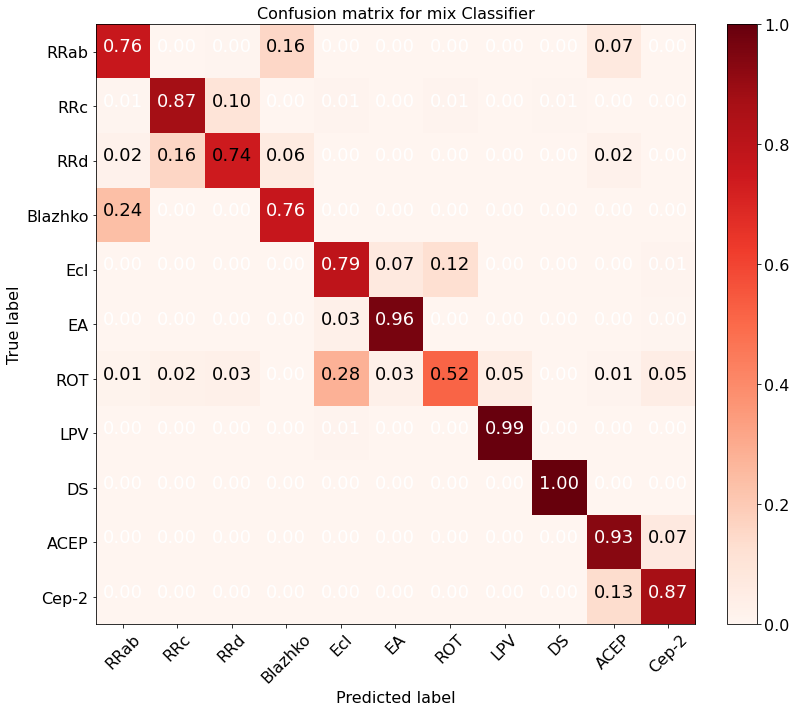

In [2]:
lodaed_model = keras.models.load_model('models/rnn_with_feature_test/model_4')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# from util import generate_batch

def generate_batch(X_sequence, X_image,  X_feature, Y, batch_size):
    idx = 0
    batch_num = len(Y)/batch_size
    while idx < batch_num:
        batch_x_sequence = X_sequence[idx * batch_size : (idx + 1) * batch_size]
        batch_x_image = X_image[idx * batch_size : (idx + 1) * batch_size]
        batch_x_feature = X_feature[idx * batch_size : (idx + 1) * batch_size]
        batch_y = Y[idx * batch_size : (idx + 1) * batch_size]
        yield batch_x_sequence, batch_x_image, batch_x_feature, batch_y
        idx += 1

test_gen = generate_batch(X_sequence_test_trimed, X_image_test, X_feature_test, Y_test, 128)      
y_label = Y_test

# train_gen = generate_batch(X_train_trimed, Y_train,128)      
# y_label = Y_train

y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
# for x, y in train_gen:
    y_predict = np.concatenate([y_predict, 
            np.argmax(lodaed_model.predict({'sequence':x_sequence, 
                                            # 'image':x_image,
                                            'feature':x_feature}), axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, normalize='true')
print(cm.shape)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(values_format='.2g')

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'ROT', 'LPV','DS','ACEP', 'Cep-2']

from util import cm_plot

plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=12,
                    cmap=plt.cm.Blues)